In [1]:
b1 = 10
b2 = 50

In [2]:
import sys
sys.path.append('/home/kboone/software/Galaxy_Bias/Bispectrum/Convert_Bispectrum/')

import h5py
import numpy as np
import pandas as pd
import scipy.fftpack as fft
from Visual_Helpers import *
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.interpolate import interp1d as inter
from scipy.interpolate import CubicSpline as spline

In [3]:
L = 2000
N = 512
kF = 2*np.pi/L
kN = N*np.pi/L

In [4]:
model_power_file = '../Two_Points_Data/CLASS_power_z1' # Location of power spectrum file
k_model_orig, Pk_model_orig = read_power(model_power_file)
max_k_model = np.max(k_model_orig)
Pk_model_orig = Pk_model_orig * (0.2322)**2 # Normalization to z=8

P_inter = spline(k_model_orig, Pk_model_orig, bc_type='natural')

log_k = np.log(k_model_orig); log_Pk = np.log(Pk_model_orig)
log_P = inter(log_k, log_Pk, bounds_error=False, fill_value='extrapolate')

def P(k, kN=kN, P_inter=P_inter, log_P=log_P, max_k=max_k_model):
    k = np.array(k)
    interpolate = k < max_k_model
    retvals = np.empty_like(k, dtype=float)

    retvals[interpolate] = P_inter(k[interpolate])

    retvals[~interpolate] = np.exp(log_P(np.log(k[~interpolate])))

    return retvals * np.exp(-(np.pi*k/(2*kN))**2)

In [5]:
k_test = np.linspace(0, 2*kN, 10000)
dk = k_test[1]-k_test[0]
sigma = np.sqrt(np.sum(k_test**2*P(k_test)/(2*np.pi**2))*dk)
# plt.figure(dpi = 120)
# plt.plot(k_test, k_test**2*P(k_test)/(2*np.pi**2))
# plt.show()

In [6]:
def generate_density_field(N, L, Pk_func):
    """
    Generates a realization of the matter density field δ(x) from a given power spectrum P(k).

    Parameters:
    - N (int): Number of grid points in each dimension.
    - L (float): Physical size of the simulation box (in units consistent with k).
    - Pk_func (callable): Function that returns P(k) given k.

    Returns:
    - delta_x (ndarray): Real-space matter density field δ(x) on a 3D grid.
    """
    dx   = L / N
    dk   = 2*np.pi / L
    k    = fft.fftfreq(N, d=dx) * 2*np.pi           # angular frequencies
    kx, ky, kz = np.meshgrid(k, k, k, indexing='ij')
    k_mag = np.sqrt(kx**2 + ky**2 + kz**2)

    # A ──────────────────────────────────────────────────────────────
    vol_prefac = (L)**1.5              # √(Δk³)
    Pk         = Pk_func(k_mag)
    rnd        = np.random.normal(size=(N,N,N)) + 1j*np.random.normal(size=(N,N,N))
    delta_k    = rnd * np.sqrt(Pk/2) * vol_prefac  # correct variance
    delta_k    = enforce_hermitian_symmetry(delta_k)
    # ────────────────────────────────────────────────────────────────

    # inverse FFT (includes its own 1/N³)
    delta_x = np.real(fft.ifftn(delta_k))

    # B ──────────────────────────────────────────────────────────────
    delta_x *= (N / L)**3                          # replace 1/N³ by 1/L³
    # ────────────────────────────────────────────────────────────────
    return delta_x
    

def enforce_hermitian_symmetry(delta_k):
    """
    Enforces Hermitian symmetry on δ(k) so that the resulting δ(x) is real.

    Parameters:
    - delta_k (ndarray): Complex k-space density field.

    Returns:
    - delta_k_sym (ndarray): Hermitian symmetric k-space density field.
    """
    N = delta_k.shape[0]
    for i in range(N):
        for j in range(N):
            for k in range(N):
                i_neg = (-i) % N
                j_neg = (-j) % N
                k_neg = (-k) % N
                delta_k[i_neg, j_neg, k_neg] = np.conj(delta_k[i, j, k])
    return delta_k

In [8]:
for ph in np.arange(25):
    if ph <= 22:
        continue
    dens_file = '../../Data/Sim_Gala_z8_Dens_512/Sim_Gala_ph0'+'{:02d}'.format(ph)+'.npy'
    delta_matter = generate_density_field(N,L,P)
    delta_galaxies = b1*delta_matter + b2*(delta_matter**2-np.std(delta_matter)**2)
    np.save(dens_file, delta_galaxies)

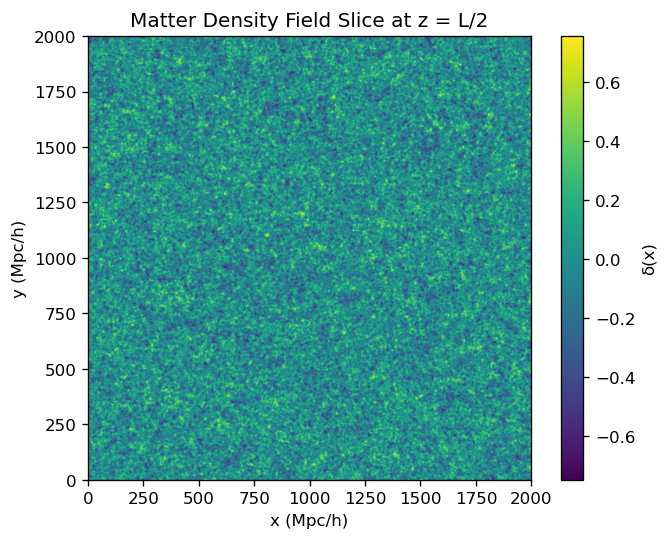

In [9]:
plt.figure(dpi=120)
plt.imshow(delta_matter[:, :, N//2], extent=(0, L, 0, L), origin='lower')
plt.colorbar(label='δ(x)')
plt.xlabel('x (Mpc/h)')
plt.ylabel('y (Mpc/h)')
plt.title('Matter Density Field Slice at z = L/2')
plt.show()

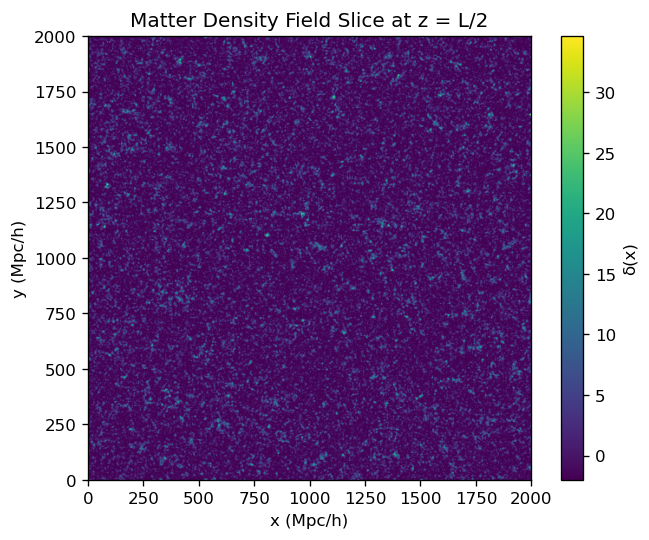

In [10]:
plt.figure(dpi=120)
plt.imshow(delta_galaxies[:, :, N//2], extent=(0, L, 0, L), origin='lower')
plt.colorbar(label='δ(x)')
plt.xlabel('x (Mpc/h)')
plt.ylabel('y (Mpc/h)')
plt.title('Matter Density Field Slice at z = L/2')
plt.show()